# Ecuación de Difusión en 2D implementado en nubes de puntos.

Función que calcula una aproximación a la solución de la ecuación de Difusión en 2D utilizando Diferencias Finitas Generalizadas en nubes de puntos.

El problema que se resuelve es:

<center>$\frac{\partial u}{\partial t}= \nu\nabla^2 u$</center>

El número de vecinos varia dependiendo del nodo.

### Parámetros de entrada
    p           m x 2       double      Matriz con las coordenadas de los m nodos.
    pb          o x 2       double      Matriz con las coordenadas de los nodos frontera.
    vec         mxnvec      double      Matriz con la correspondencia de los vecinos de cada nodo.
    fDIF                    function    Función declarada con la condición inicial y de frontera.

### Parámetros de salida
    u_ap        m x 1       double      Vector con la aproximación calculada por el método.
    u_ex        m x 1       double      Vector con la solución exacta del problema.

In [6]:
# Se elige la nube en la que se va a trabajar
nube = 'CAB_1'

# Se elige el tamaño de la discretización temporal
t   = 1000

# Se elige el coeficiente de difusion
nu = 0.4

## Inicialización del Problema
Se inicializa lo necesario para el problema:


1.   Se importan las librerías necesarias.
2.   Se cargan los datos de la región.
3.   Se definen las condiciones iniciales y de frontera.

### Importación de Librerias
En esta parte se importan las librerias necesarias para ejecutar todo el código. En particual se importan:

*   **numpy**. Para poder hacer la mayor parte de los cálculos numéricos.
*   **math**. Permite hacer uso de diferentes funciones matemáticas.
*   **matplotlib**. Para hacer las gráficas necesarias.
*   **scipy**. Para usar una gran cantidad de funciones matemáticas.

In [10]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sys import path
from scipy.io import loadmat
path.insert(0, '../Generales/')
from Gammas import Gammas_cloud as Gammas
from Errores import ECM_cloud_transient as ECM
from Graficar import graph_cloud_transient as Graph
from Graficar import graphEr

### Se cargan los datos de la region

En esta parte se cargan los datos de la region desde un archivo .mat y se guardan en sus respectivas variables $p$, $pb$ y $vec$.

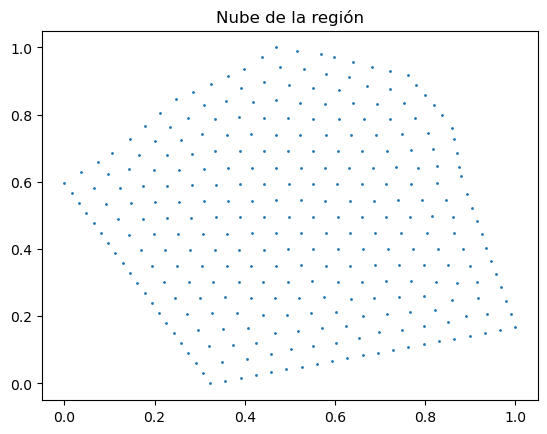

In [3]:
# Se cargan todos los datos desde el archivo
mat = loadmat('../Regiones/Nubes/' + nube + '.mat')

# Se guardan los datos de los nodos
p   = mat['p']
pb  = mat['pb']
vec = mat['vec']

# Se imprimen los nodos para asegurarnos de que se cargan correctamente.
plt.scatter(p[:,0],  p[:,1],  s = 1)
plt.title('Nube de la región')
plt.show()

### Se definen las condiciones iniciales y de frontera

Las condiciones iniciales y de frontera serán definidas como:
<center>
  $f = e^{-2*\pi^2vt}\cos(\pi x)cos(\pi y)$
</center>

In [4]:
def fDIF(x, y, t, v):
  fun = math.exp(-2*math.pi**2*v*t)*math.cos(math.pi*x)*math.cos(math.pi*y)
  return fun

## Diferencias Finitas Generalizadas
En esta parte se implementa el método de Diferencias Finitas Generalizadas sobre nubes de puntos.

Se realizan las siguientes operaciones:

1.   Se calculan los valores de Gamma.
2.   Se hace el Método de Diferencias Finitas Generalizadas.

### Se implementa el método de Diferencias Finitas Generalizadas.

Se resuelve el problema de Diferencias Finitas Generalizadas. Desde aquí se manda a llamar a las rutinas para buscar vecinos y calcular las Gammas.

In [5]:
def Diffusion_Cloud(p, pb, vec, f, nu, t):
  m    = len(p[:,0])                                                             # Se encuentra el número de nodos.
  mf   = len(pb[:,0])                                                            # Se encuentra el número de nodos de frontera.
  #mm   = len(p[np.arange(mf,m),0])                                               # Se encuentra el número de nodos interiores.
  T    = np.linspace(0,1,t)                                                       # Se hace la malla en el tiempo.
  dt   = T[1] - T[0]                                                             # Se calcula dt.
  tol  = np.finfo(float).eps                                                     # La tolerancia será eps.
  u_ap = np.zeros([m,t])                                                         # Se inicializa u_ap con ceros.
  u_ex = np.zeros([m,t])                                                         # Se inicializa u_ex con ceros.

  ## Condiciones de Frontera
  for k in np.arange(t):
    for i in np.arange(mf):                                                      # Para cada uno de los nodos de frontera.
      u_ap[i, k] = f(pb[i, 0], pb[i, 1], T[k], nu)                               # Se agrega la condición de frontera.
  
  ## Condición Inicial
  for i in np.arange(m):                                                         # Para cada uno de los nodos
    u_ap[i, 0] = f(p[i, 0], p[i, 1], T[0], nu)                                 # Se agrega la condición inicial

  # Ahora, se calculan las Gammas
  L = np.vstack([[0], [0], [2*nu*dt], [0], [2*nu*dt]])                           # Se asignan los valores para el operador diferencial.
  Gamma = Gammas(p, pb, vec, L)                                                  # Se calculan las Gammas.


  for k in np.arange(1,t):
    for i in np.arange(mf, m):
      utemp = 0
      nvec = sum(vec[i,:] != 0)                                                  # Se calcula el número de vecinos que tiene el nodo.
      for j in np.arange(1,nvec+1):
        utemp = utemp + Gamma[i,j]*u_ap[int(vec[i, j-1])-1, k-1]
      utemp = utemp + Gamma[i,0]*u_ap[i, k-1]
      u_ap[i,k] = u_ap[i, k-1] + utemp

  for k in np.arange(t):
    for i in np.arange(m):                                                       # Para cada uno de los nodos.
      u_ex[i,k] = f(p[i,0], p[i,1], T[k], nu)                                    # Se coloca la solución exacta.

  return u_ap, u_ex, vec

## Ejecución

En esta parte se ejecuta el código para obtener los resultados. También se grafica la solución.

In [7]:
u_ap, u_ex, vec = Diffusion_Cloud(p, pb, vec, fDIF, nu, t)

El error máximo cometido para el método es de:  3.780261423777125e-05


TypeError: graph_cloud_transient() takes 2 positional arguments but 3 were given

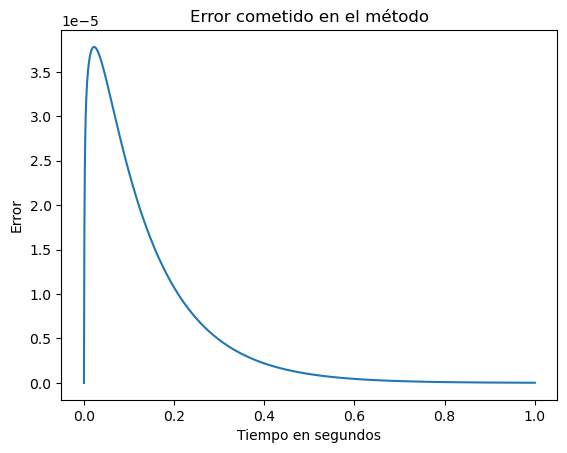

In [12]:
er = ECM(p, vec, u_ap, u_ex)
print('El error máximo cometido para el método es de: ', er.max())
graphEr(er)
Graph(p, u_ap, u_ex)